In [2]:
# general imports
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import torch

In [3]:
# filter python warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
# prepare CIFAR data
import torchvision.datasets as datasets

scale = np.mean(np.arange(0, 256))
normalize = lambda x: (x - scale) / scale

# train data
cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
cifar_train_images = normalize(cifar_trainset.train_data)
cifar_train_labels = np.array(cifar_trainset.train_labels)

# get only train images and labels for two classes: 3 (cat) and 5 (dog)
cifar_train_images_3_5 = np.concatenate([cifar_train_images[cifar_train_labels==3], cifar_train_images[cifar_train_labels==5]])
cifar_train_labels_3_5 = np.concatenate([np.repeat(0, np.sum(cifar_train_labels==3)), np.repeat(1, np.sum(cifar_train_labels==5))])

# test data
cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=None)
cifar_test_images = normalize(cifar_testset.test_data)
cifar_test_labels = np.array(cifar_testset.test_labels)

# get only test images and labels for two classes: 3 (cat) and 5 (dog)
cifar_test_images_3_5 = np.concatenate([cifar_test_images[cifar_test_labels==3], cifar_test_images[cifar_test_labels==5]])
cifar_test_labels_3_5 = np.concatenate([np.repeat(0, np.sum(cifar_test_labels==3)), np.repeat(1, np.sum(cifar_test_labels==5))])
# print(np.min(cifar_train_images_3_5))
# print(np.max(cifar_train_images_3_5))

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# All of CIFAR 10
print(cifar_train_images.shape)
print(cifar_test_images.shape)
print(np.unique(cifar_test_labels))

(50000, 32, 32, 3)
(10000, 32, 32, 3)
[0 1 2 3 4 5 6 7 8 9]


In [6]:
# Cats vs Dogs (CIFAR)
print(cifar_train_images_3_5.shape)
print(cifar_test_images_3_5.shape)
print(np.unique(cifar_test_labels_3_5))

(10000, 32, 32, 3)
(2000, 32, 32, 3)
[0 1]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: 0


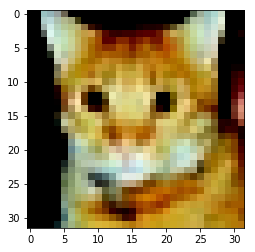

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: 1


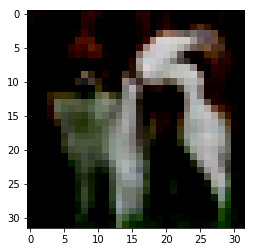

In [7]:
# visualize data and labels
import matplotlib.pyplot as plt
%matplotlib inline

# 3 (label 0)
index = 2500
print("Label:", cifar_train_labels_3_5[index])
plt.imshow(cifar_train_images_3_5[index])
plt.show()

# 5 (label 1)
index = 7500
print("Label:", cifar_train_labels_3_5[index])
plt.imshow(cifar_train_images_3_5[index])
plt.show()

In [7]:
# Naive Random Forest - by flattening the entire image
# Train
clf = RandomForestClassifier()
clf.fit(cifar_train_images_3_5.reshape(-1, 32*32*3), cifar_train_labels_3_5)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [8]:
# Naive Random Forest - by flattening the entire image
# Test
cifar_test_preds_3_5 = clf.predict(cifar_test_images_3_5.reshape(-1, 32*32*3))
print("Test Accuracy: " + str(accuracy_score(cifar_test_labels_3_5, cifar_test_preds_3_5)))
print("Validation Confusion Matrix: \n" + str(confusion_matrix(cifar_test_labels_3_5, cifar_test_preds_3_5)))

Test Accuracy: 0.6035
Validation Confusion Matrix: 
[[689 311]
 [482 518]]


In [9]:
# The Deep Convolution Random Forest class (for binary classification)
class ConvRF(object):
    def __init__(self, kernel_size=5, stride=2):
        self.kernel_size = kernel_size
        self.stride = stride
        self.kernel_forests = None

    def _convolve_chop(self, images, labels=None, flatten=False):

        batch_size, in_dim, _, num_channels = images.shape

        out_dim = int((in_dim - self.kernel_size) / self.stride) + 1  # calculate output dimensions

        # create matrix to hold the chopped images
        out_images = np.zeros((batch_size, out_dim, out_dim,
                               self.kernel_size, self.kernel_size, num_channels))
        out_labels = None

        curr_y = out_y = 0
        # move kernel vertically across the image
        while curr_y + self.kernel_size <= in_dim:
            curr_x = out_x = 0
            # move kernel horizontally across the image
            while curr_x + self.kernel_size <= in_dim:
                # chop images
                out_images[:, out_x, out_y] = images[:, curr_x:curr_x +
                                                     self.kernel_size, curr_y:curr_y+self.kernel_size, :]
                curr_x += self.stride
                out_x += 1
            curr_y += self.stride
            out_y += 1

        if flatten:
            out_images = out_images.reshape(batch_size, out_dim, out_dim, -1)

        if labels is not None:
            out_labels = np.zeros((batch_size, out_dim, out_dim))
            out_labels[:, ] = labels.reshape(-1, 1, 1)

        return out_images, out_labels

    def convolve_fit(self, images, labels):
        num_channels = images.shape[-1]
        sub_images, sub_labels = self._convolve_chop(images, labels=labels, flatten=True)

        batch_size, out_dim, _, _ = sub_images.shape
        self.kernel_forests = np.zeros((out_dim, out_dim), dtype=np.int).tolist()
        convolved_image = np.zeros((images.shape[0], out_dim, out_dim, 1))
        
        for i in range(out_dim):
            for j in range(out_dim):
                self.kernel_forests[i][j] = RandomForestClassifier()
                self.kernel_forests[i][j].fit(sub_images[:, i, j], sub_labels[:, i, j])
                convolved_image[:, i, j] = self.kernel_forests[i][j].predict_proba(sub_images[:, i, j])[..., 1][..., np.newaxis]
        return convolved_image

    def convolve_predict(self, images):
        if not self.kernel_forests:
            raise Exception("Should fit training data before predicting")

        num_channels = images.shape[-1]
        sub_images, _ = self._convolve_chop(images, flatten=True)

        batch_size, out_dim, _, _ = sub_images.shape
        
        kernel_predictions = np.zeros((images.shape[0], out_dim, out_dim, 1))
        
        for i in range(out_dim):
            for j in range(out_dim):
                kernel_predictions[:, i, j] = self.kernel_forests[i][j].predict_proba(sub_images[:, i, j])[..., 1][..., np.newaxis]
        return kernel_predictions

In [10]:
##########################################################
print("Experiment 1:")
print("No. of ConvRFs: 1")
print("Kernel Size: (3,3); Stride: 2")
print("Technique: Posteriors (fn: rf.predict_proba())")
## Train
# ConvRF (layer 1)
conv1 = ConvRF(kernel_size=3, stride=2)
conv1_map = conv1.convolve_fit(cifar_train_images_3_5, cifar_train_labels_3_5)
print("ConvRF map output shape:", conv1_map.shape[1:-1])

# Full RF
conv1_full_RF = RandomForestClassifier()
conv1_full_RF.fit(conv1_map.reshape(len(cifar_train_images_3_5), -1), cifar_train_labels_3_5)

## Test (after ConvRF 1 and Full RF)
conv1_map_test = conv1.convolve_predict(cifar_test_images_3_5)
cifar_test_preds = conv1_full_RF.predict(conv1_map_test.reshape(len(cifar_test_images_3_5), -1))

print("Test Accuracy: " + str(accuracy_score(cifar_test_labels_3_5, cifar_test_preds)))
print("Validation Confusion Matrix: \n" + str(confusion_matrix(cifar_test_labels_3_5, cifar_test_preds)))

Experiment 1:
No. of ConvRFs: 1
Kernel Size: (3,3); Stride: 2
Technique: Posteriors (fn: rf.predict_proba())
ConvRF map output shape: (15, 15)
Test Accuracy: 0.616
Validation Confusion Matrix: 
[[672 328]
 [440 560]]


In [11]:
##########################################################
print("Experiment 2:")
print("No. of ConvRFs: 1")
print("Kernel Size: (5,5); Stride: 2")
print("Technique: Posteriors (fn: rf.predict_proba())")
## Train
# ConvRF (layer 1)
conv1 = ConvRF(kernel_size=5, stride=2)
conv1_map = conv1.convolve_fit(cifar_train_images_3_5, cifar_train_labels_3_5)
print("ConvRF map output shape:", conv1_map.shape[1:-1])

# Full RF
conv1_full_RF = RandomForestClassifier()
conv1_full_RF.fit(conv1_map.reshape(len(cifar_train_images_3_5), -1), cifar_train_labels_3_5)

## Test (after ConvRF 1 and Full RF)
conv1_map_test = conv1.convolve_predict(cifar_test_images_3_5)
cifar_test_preds = conv1_full_RF.predict(conv1_map_test.reshape(len(cifar_test_images_3_5), -1))

print("Test Accuracy: " + str(accuracy_score(cifar_test_labels_3_5, cifar_test_preds)))
print("Validation Confusion Matrix: \n" + str(confusion_matrix(cifar_test_labels_3_5, cifar_test_preds)))

Experiment 2:
No. of ConvRFs: 1
Kernel Size: (5,5); Stride: 2
Technique: Posteriors (fn: rf.predict_proba())
ConvRF map output shape: (14, 14)
Test Accuracy: 0.6495
Validation Confusion Matrix: 
[[732 268]
 [433 567]]


In [12]:
##########################################################
print("Experiment 3:")
print("No. of ConvRFs: 1")
print("Kernel Size: (10,10); Stride: 2")
print("Technique: Posteriors (fn: rf.predict_proba())")
## Train
# ConvRF (layer 1)
conv1 = ConvRF(kernel_size=10, stride=2)
conv1_map = conv1.convolve_fit(cifar_train_images_3_5, cifar_train_labels_3_5)
print("ConvRF map output shape:", conv1_map.shape[1:-1])

# Full RF
conv1_full_RF = RandomForestClassifier()
conv1_full_RF.fit(conv1_map.reshape(len(cifar_train_images_3_5), -1), cifar_train_labels_3_5)

## Test (after ConvRF 1 and Full RF)
conv1_map_test = conv1.convolve_predict(cifar_test_images_3_5)
cifar_test_preds = conv1_full_RF.predict(conv1_map_test.reshape(len(cifar_test_images_3_5), -1))

print("Test Accuracy: " + str(accuracy_score(cifar_test_labels_3_5, cifar_test_preds)))
print("Validation Confusion Matrix: \n" + str(confusion_matrix(cifar_test_labels_3_5, cifar_test_preds)))

Experiment 3:
No. of ConvRFs: 1
Kernel Size: (10,10); Stride: 2
Technique: Posteriors (fn: rf.predict_proba())
ConvRF map output shape: (12, 12)
Test Accuracy: 0.6685
Validation Confusion Matrix: 
[[724 276]
 [387 613]]


In [17]:
##########################################################
print("Experiment 4:")
print("No. of ConvRFs: 1")
print("Kernel Size: (15,15); Stride: 2")
print("Technique: Posteriors (fn: rf.predict_proba())")
## Train
# ConvRF (layer 1)
conv1 = ConvRF(kernel_size=15, stride=2)
conv1_map = conv1.convolve_fit(cifar_train_images_3_5, cifar_train_labels_3_5)
print(conv1_map.shape)
print("ConvRF map output shape:", conv1_map.shape[1:-1])

# Full RF
conv1_full_RF = RandomForestClassifier()
conv1_full_RF.fit(conv1_map.reshape(len(cifar_train_images_3_5), -1), cifar_train_labels_3_5)

## Test (after ConvRF 1 and Full RF)
conv1_map_test = conv1.convolve_predict(cifar_test_images_3_5)
cifar_test_preds = conv1_full_RF.predict(conv1_map_test.reshape(len(cifar_test_images_3_5), -1))

print("Test Accuracy: " + str(accuracy_score(cifar_test_labels_3_5, cifar_test_preds)))
print("Validation Confusion Matrix: \n" + str(confusion_matrix(cifar_test_labels_3_5, cifar_test_preds)))

Experiment 4:
No. of ConvRFs: 1
Kernel Size: (15,15); Stride: 2
Technique: Posteriors (fn: rf.predict_proba())
(10000, 9, 9, 1)
ConvRF map output shape: (9, 9)
Test Accuracy: 0.655
Validation Confusion Matrix: 
[[696 304]
 [386 614]]


In [10]:
##########################################################
print("Experiment 5:")
print("No. of ConvRFs: 1")
print("Kernel Size: (13,13); Stride: 2")
print("Technique: Posteriors (fn: rf.predict_proba())")
## Train
# ConvRF (layer 1)
conv1 = ConvRF(kernel_size=13, stride=2)
conv1_map = conv1.convolve_fit(cifar_train_images_3_5, cifar_train_labels_3_5)
print(conv1_map.shape)
print("ConvRF map output shape:", conv1_map.shape[1:-1])

# Full RF
conv1_full_RF = RandomForestClassifier()
conv1_full_RF.fit(conv1_map.reshape(len(cifar_train_images_3_5), -1), cifar_train_labels_3_5)

## Test (after ConvRF 1 and Full RF)
conv1_map_test = conv1.convolve_predict(cifar_test_images_3_5)
cifar_test_preds = conv1_full_RF.predict(conv1_map_test.reshape(len(cifar_test_images_3_5), -1))

print("Test Accuracy: " + str(accuracy_score(cifar_test_labels_3_5, cifar_test_preds)))
print("Validation Confusion Matrix: \n" + str(confusion_matrix(cifar_test_labels_3_5, cifar_test_preds)))

Experiment 5:
No. of ConvRFs: 1
Kernel Size: (13,13); Stride: 2
Technique: Posteriors (fn: rf.predict_proba())
(10000, 10, 10, 1)
ConvRF map output shape: (10, 10)
Test Accuracy: 0.6635
Validation Confusion Matrix: 
[[690 310]
 [363 637]]


In [15]:
##########################################################
print("Experiment 6:")
print("No. of ConvRFs: 1")
print("Kernel Size: (17,17); Stride: 2")
print("Technique: Posteriors (fn: rf.predict_proba())")
## Train
# ConvRF (layer 1)
conv1 = ConvRF(kernel_size=17, stride=2)
conv1_map = conv1.convolve_fit(cifar_train_images_3_5, cifar_train_labels_3_5)
print(conv1_map.shape)
print("ConvRF map output shape:", conv1_map.shape[1:-1])

# Full RF
conv1_full_RF = RandomForestClassifier()
conv1_full_RF.fit(conv1_map.reshape(len(cifar_train_images_3_5), -1), cifar_train_labels_3_5)

## Test (after ConvRF 1 and Full RF)
conv1_map_test = conv1.convolve_predict(cifar_test_images_3_5)
cifar_test_preds = conv1_full_RF.predict(conv1_map_test.reshape(len(cifar_test_images_3_5), -1))

print("Test Accuracy: " + str(accuracy_score(cifar_test_labels_3_5, cifar_test_preds)))
print("Validation Confusion Matrix: \n" + str(confusion_matrix(cifar_test_labels_3_5, cifar_test_preds)))

Experiment 6:
No. of ConvRFs: 1
Kernel Size: (17,17); Stride: 2
Technique: Posteriors (fn: rf.predict_proba())
(10000, 8, 8, 1)
ConvRF map output shape: (8, 8)
Test Accuracy: 0.658
Validation Confusion Matrix: 
[[701 299]
 [385 615]]


In [18]:
##########################################################
print("Experiment 7:")
print("No. of ConvRFs: 2")
print("ConvRF 1 -> Kernel Size: (13,13); Stride: 2") 
print("ConvRF 2 -> Kernel Size: (3,3); Stride: 1") 
print("Technique: Posteriors (fn: rf.predict_proba())")

## Train
# ConvRF (layer 1)
conv1 = ConvRF(kernel_size=13, stride=2)
conv1_map = conv1.convolve_fit(cifar_train_images_3_5, cifar_train_labels_3_5)
print("ConvRF 1 map output shape:", conv1_map.shape[1:-1])

# ConvRF (layer 2)
conv2 = ConvRF(kernel_size=3, stride=1)
conv2_map = conv2.convolve_fit(conv1_map, cifar_train_labels_3_5)
print("ConvRF 2 map output shape:", conv2_map.shape[1:-1])

# Full RF
conv2_full_RF = RandomForestClassifier()
conv2_full_RF.fit(conv2_map.reshape(len(cifar_train_images_3_5), -1), cifar_train_labels_3_5)

## Test (after ConvRF 1, ConvRF 2 and Full RF)
conv1_map_test = conv1.convolve_predict(cifar_test_images_3_5)
conv2_map_test = conv2.convolve_predict(conv1_map_test)
cifar_test_preds = conv2_full_RF.predict(conv2_map_test.reshape(len(cifar_test_images_3_5), -1))


print("Test Accuracy: " + str(accuracy_score(cifar_test_labels_3_5, cifar_test_preds)))
print("Validation Confusion Matrix: \n" + str(confusion_matrix(cifar_test_labels_3_5, cifar_test_preds)))

Experiment 7:
No. of ConvRFs: 2
ConvRF 1 -> Kernel Size: (13,13); Stride: 2
ConvRF 2 -> Kernel Size: (3,3); Stride: 1
Technique: Posteriors (fn: rf.predict_proba())
ConvRF 1 map output shape: (10, 10)
ConvRF 2 map output shape: (8, 8)
Test Accuracy: 0.6825
Validation Confusion Matrix: 
[[700 300]
 [335 665]]


In [19]:
##########################################################
print("Experiment 8:")
print("No. of ConvRFs: 2")
print("ConvRF 1 -> Kernel Size: (13,13); Stride: 2") 
print("ConvRF 2 -> Kernel Size: (3,3); Stride: 2") 
print("Technique: Posteriors (fn: rf.predict_proba())")

## Train
# ConvRF (layer 1)
conv1 = ConvRF(kernel_size=13, stride=2)
conv1_map = conv1.convolve_fit(cifar_train_images_3_5, cifar_train_labels_3_5)
print("ConvRF 1 map output shape:", conv1_map.shape[1:-1])

# ConvRF (layer 2)
conv2 = ConvRF(kernel_size=3, stride=2)
conv2_map = conv2.convolve_fit(conv1_map, cifar_train_labels_3_5)
print("ConvRF 2 map output shape:", conv2_map.shape[1:-1])

# Full RF
conv2_full_RF = RandomForestClassifier()
conv2_full_RF.fit(conv2_map.reshape(len(cifar_train_images_3_5), -1), cifar_train_labels_3_5)

## Test (after ConvRF 1, ConvRF 2 and Full RF)
conv1_map_test = conv1.convolve_predict(cifar_test_images_3_5)
conv2_map_test = conv2.convolve_predict(conv1_map_test)
cifar_test_preds = conv2_full_RF.predict(conv2_map_test.reshape(len(cifar_test_images_3_5), -1))


print("Test Accuracy: " + str(accuracy_score(cifar_test_labels_3_5, cifar_test_preds)))
print("Validation Confusion Matrix: \n" + str(confusion_matrix(cifar_test_labels_3_5, cifar_test_preds)))

Experiment 8:
No. of ConvRFs: 2
ConvRF 1 -> Kernel Size: (13,13); Stride: 2
ConvRF 2 -> Kernel Size: (3,3); Stride: 2
Technique: Posteriors (fn: rf.predict_proba())
ConvRF 1 map output shape: (10, 10)
ConvRF 2 map output shape: (4, 4)
Test Accuracy: 0.6695
Validation Confusion Matrix: 
[[718 282]
 [379 621]]


In [20]:
##########################################################
print("Experiment 9:")
print("No. of ConvRFs: 2")
print("ConvRF 1 -> Kernel Size: (13,13); Stride: 2") 
print("ConvRF 2 -> Kernel Size: (5,5); Stride: 1") 
print("Technique: Posteriors (fn: rf.predict_proba())")

## Train
# ConvRF (layer 1)
conv1 = ConvRF(kernel_size=13, stride=2)
conv1_map = conv1.convolve_fit(cifar_train_images_3_5, cifar_train_labels_3_5)
print("ConvRF 1 map output shape:", conv1_map.shape[1:-1])

# ConvRF (layer 2)
conv2 = ConvRF(kernel_size=5, stride=1)
conv2_map = conv2.convolve_fit(conv1_map, cifar_train_labels_3_5)
print("ConvRF 2 map output shape:", conv2_map.shape[1:-1])

# Full RF
conv2_full_RF = RandomForestClassifier()
conv2_full_RF.fit(conv2_map.reshape(len(cifar_train_images_3_5), -1), cifar_train_labels_3_5)

## Test (after ConvRF 1, ConvRF 2 and Full RF)
conv1_map_test = conv1.convolve_predict(cifar_test_images_3_5)
conv2_map_test = conv2.convolve_predict(conv1_map_test)
cifar_test_preds = conv2_full_RF.predict(conv2_map_test.reshape(len(cifar_test_images_3_5), -1))


print("Test Accuracy: " + str(accuracy_score(cifar_test_labels_3_5, cifar_test_preds)))
print("Validation Confusion Matrix: \n" + str(confusion_matrix(cifar_test_labels_3_5, cifar_test_preds)))

Experiment 9:
No. of ConvRFs: 2
ConvRF 1 -> Kernel Size: (13,13); Stride: 2
ConvRF 2 -> Kernel Size: (5,5); Stride: 1
Technique: Posteriors (fn: rf.predict_proba())
ConvRF 1 map output shape: (10, 10)
ConvRF 2 map output shape: (6, 6)
Test Accuracy: 0.673
Validation Confusion Matrix: 
[[679 321]
 [333 667]]


In [21]:
##########################################################
print("Experiment 10:")
print("No. of ConvRFs: 2")
print("ConvRF 1 -> Kernel Size: (13,13); Stride: 2") 
print("ConvRF 2 -> Kernel Size: (5,5); Stride: 2") 
print("Technique: Posteriors (fn: rf.predict_proba())")

## Train
# ConvRF (layer 1)
conv1 = ConvRF(kernel_size=13, stride=2)
conv1_map = conv1.convolve_fit(cifar_train_images_3_5, cifar_train_labels_3_5)
print("ConvRF 1 map output shape:", conv1_map.shape[1:-1])

# ConvRF (layer 2)
conv2 = ConvRF(kernel_size=5, stride=2)
conv2_map = conv2.convolve_fit(conv1_map, cifar_train_labels_3_5)
print("ConvRF 2 map output shape:", conv2_map.shape[1:-1])

# Full RF
conv2_full_RF = RandomForestClassifier()
conv2_full_RF.fit(conv2_map.reshape(len(cifar_train_images_3_5), -1), cifar_train_labels_3_5)

## Test (after ConvRF 1, ConvRF 2 and Full RF)
conv1_map_test = conv1.convolve_predict(cifar_test_images_3_5)
conv2_map_test = conv2.convolve_predict(conv1_map_test)
cifar_test_preds = conv2_full_RF.predict(conv2_map_test.reshape(len(cifar_test_images_3_5), -1))


print("Test Accuracy: " + str(accuracy_score(cifar_test_labels_3_5, cifar_test_preds)))
print("Validation Confusion Matrix: \n" + str(confusion_matrix(cifar_test_labels_3_5, cifar_test_preds)))

Experiment 10:
No. of ConvRFs: 2
ConvRF 1 -> Kernel Size: (13,13); Stride: 2
ConvRF 2 -> Kernel Size: (5,5); Stride: 2
Technique: Posteriors (fn: rf.predict_proba())
ConvRF 1 map output shape: (10, 10)
ConvRF 2 map output shape: (3, 3)
Test Accuracy: 0.684
Validation Confusion Matrix: 
[[674 326]
 [306 694]]


In [22]:
##########################################################
print("Experiment 11:")
print("No. of ConvRFs: 2")
print("ConvRF 1 -> Kernel Size: (13,13); Stride: 2") 
print("ConvRF 2 -> Kernel Size: (7,7); Stride: 1") 
print("Technique: Posteriors (fn: rf.predict_proba())")

## Train
# ConvRF (layer 1)
conv1 = ConvRF(kernel_size=13, stride=2)
conv1_map = conv1.convolve_fit(cifar_train_images_3_5, cifar_train_labels_3_5)
print("ConvRF 1 map output shape:", conv1_map.shape[1:-1])

# ConvRF (layer 2)
conv2 = ConvRF(kernel_size=7, stride=1)
conv2_map = conv2.convolve_fit(conv1_map, cifar_train_labels_3_5)
print("ConvRF 2 map output shape:", conv2_map.shape[1:-1])

# Full RF
conv2_full_RF = RandomForestClassifier()
conv2_full_RF.fit(conv2_map.reshape(len(cifar_train_images_3_5), -1), cifar_train_labels_3_5)

## Test (after ConvRF 1, ConvRF 2 and Full RF)
conv1_map_test = conv1.convolve_predict(cifar_test_images_3_5)
conv2_map_test = conv2.convolve_predict(conv1_map_test)
cifar_test_preds = conv2_full_RF.predict(conv2_map_test.reshape(len(cifar_test_images_3_5), -1))


print("Test Accuracy: " + str(accuracy_score(cifar_test_labels_3_5, cifar_test_preds)))
print("Validation Confusion Matrix: \n" + str(confusion_matrix(cifar_test_labels_3_5, cifar_test_preds)))

Experiment 11:
No. of ConvRFs: 2
ConvRF 1 -> Kernel Size: (13,13); Stride: 2
ConvRF 2 -> Kernel Size: (7,7); Stride: 1
Technique: Posteriors (fn: rf.predict_proba())
ConvRF 1 map output shape: (10, 10)
ConvRF 2 map output shape: (4, 4)
Test Accuracy: 0.6485
Validation Confusion Matrix: 
[[650 350]
 [353 647]]


In [23]:
##########################################################
print("Experiment 12:")
print("No. of ConvRFs: 2")
print("ConvRF 1 -> Kernel Size: (13,13); Stride: 2") 
print("ConvRF 2 -> Kernel Size: (7,7); Stride: 2") 
print("Technique: Posteriors (fn: rf.predict_proba())")

## Train
# ConvRF (layer 1)
conv1 = ConvRF(kernel_size=13, stride=2)
conv1_map = conv1.convolve_fit(cifar_train_images_3_5, cifar_train_labels_3_5)
print("ConvRF 1 map output shape:", conv1_map.shape[1:-1])

# ConvRF (layer 2)
conv2 = ConvRF(kernel_size=7, stride=2)
conv2_map = conv2.convolve_fit(conv1_map, cifar_train_labels_3_5)
print("ConvRF 2 map output shape:", conv2_map.shape[1:-1])

# Full RF
conv2_full_RF = RandomForestClassifier()
conv2_full_RF.fit(conv2_map.reshape(len(cifar_train_images_3_5), -1), cifar_train_labels_3_5)

## Test (after ConvRF 1, ConvRF 2 and Full RF)
conv1_map_test = conv1.convolve_predict(cifar_test_images_3_5)
conv2_map_test = conv2.convolve_predict(conv1_map_test)
cifar_test_preds = conv2_full_RF.predict(conv2_map_test.reshape(len(cifar_test_images_3_5), -1))


print("Test Accuracy: " + str(accuracy_score(cifar_test_labels_3_5, cifar_test_preds)))
print("Validation Confusion Matrix: \n" + str(confusion_matrix(cifar_test_labels_3_5, cifar_test_preds)))

Experiment 12:
No. of ConvRFs: 2
ConvRF 1 -> Kernel Size: (13,13); Stride: 2
ConvRF 2 -> Kernel Size: (7,7); Stride: 2
Technique: Posteriors (fn: rf.predict_proba())
ConvRF 1 map output shape: (10, 10)
ConvRF 2 map output shape: (2, 2)
Test Accuracy: 0.659
Validation Confusion Matrix: 
[[640 360]
 [322 678]]


In [ ]:
##########################################################
print("Experiment 13:")
print("No. of ConvRFs: 3")
print("ConvRF 1 -> Kernel Size: (13,13); Stride: 2") 
print("ConvRF 2 -> Kernel Size: (5,5); Stride: 1") 
print("ConvRF 3 -> Kernel Size: (2,2); Stride: 1") 
print("Technique: Posteriors (fn: rf.predict_proba())")

## Train
# ConvRF (layer 1)
conv1 = ConvRF(kernel_size=13, stride=2)
conv1_map = conv1.convolve_fit(cifar_train_images_3_5, cifar_train_labels_3_5)
print("ConvRF 1 map output shape:", conv1_map.shape[1:-1])

# ConvRF (layer 2)
conv2 = ConvRF(kernel_size=5, stride=1)
conv2_map = conv2.convolve_fit(conv1_map, cifar_train_labels_3_5)
print("ConvRF 2 map output shape:", conv2_map.shape[1:-1])

# ConvRF (layer 3)
conv3 = ConvRF(kernel_size=2, stride=1)
conv3_map = conv3.convolve_fit(conv2_map, cifar_train_labels_3_5)
print("ConvRF 3 map output shape:", conv3_map.shape[1:-1])

# Full RF
conv3_full_RF = RandomForestClassifier()
conv3_full_RF.fit(conv3_map.reshape(len(cifar_train_images_3_5), -1), cifar_train_labels_3_5)

## Test (after ConvRF 1, ConvRF 2, ConvRF 3 and Full RF)
conv1_map_test = conv1.convolve_predict(cifar_test_images_3_5)
conv2_map_test = conv2.convolve_predict(conv1_map_test)
conv3_map_test = conv3.convolve_predict(conv2_map_test)
cifar_test_preds = conv3_full_RF.predict(conv3_map_test.reshape(len(cifar_test_images_3_5), -1))

print("Test Accuracy: " + str(accuracy_score(cifar_test_labels_3_5, cifar_test_preds)))
print("Validation Confusion Matrix: \n" + str(confusion_matrix(cifar_test_labels_3_5, cifar_test_preds)))

In [ ]:
##########################################################
print("Experiment 14:")
print("No. of ConvRFs: 3")
print("ConvRF 1 -> Kernel Size: (15,15); Stride: 2") 
print("ConvRF 2 -> Kernel Size: (5,5); Stride: 1") 
print("ConvRF 3 -> Kernel Size: (3,3); Stride: 1") 
print("Technique: Posteriors (fn: rf.predict_proba())")

## Train
# ConvRF (layer 1)
conv1 = ConvRF(kernel_size=10, stride=2)
conv1_map = conv1.convolve_fit(cifar_train_images_3_5, cifar_train_labels_3_5)
print("ConvRF 1 map output shape:", conv1_map.shape[1:-1])

# ConvRF (layer 2)
conv2 = ConvRF(kernel_size=5, stride=1)
conv2_map = conv2.convolve_fit(conv1_map, cifar_train_labels_3_5)
print("ConvRF 2 map output shape:", conv2_map.shape[1:-1])

# ConvRF (layer 3)
conv3 = ConvRF(kernel_size=3, stride=1)
conv3_map = conv3.convolve_fit(conv2_map, cifar_train_labels_3_5)
print("ConvRF 3 map output shape:", conv3_map.shape[1:-1])

# Full RF
conv3_full_RF = RandomForestClassifier()
conv3_full_RF.fit(conv3_map.reshape(len(cifar_train_images_3_5), -1), cifar_train_labels_3_5)

## Test (after ConvRF 1, ConvRF 2, ConvRF 3 and Full RF)
conv1_map_test = conv1.convolve_predict(cifar_test_images_3_5)
conv2_map_test = conv2.convolve_predict(conv1_map_test)
conv3_map_test = conv3.convolve_predict(conv2_map_test)
cifar_test_preds = conv3_full_RF.predict(conv3_map_test.reshape(len(cifar_test_images_3_5), -1))

print("Test Accuracy: " + str(accuracy_score(cifar_test_labels_3_5, cifar_test_preds)))
print("Validation Confusion Matrix: \n" + str(confusion_matrix(cifar_test_labels_3_5, cifar_test_preds)))

In [ ]:
##########################################################
print("Experiment 15:")
print("No. of ConvRFs: 3")
print("ConvRF 1 -> Kernel Size: (15,15); Stride: 2") 
print("ConvRF 2 -> Kernel Size: (7,7); Stride: 1") 
print("ConvRF 3 -> Kernel Size: (2,2); Stride: 1") 
print("Technique: Posteriors (fn: rf.predict_proba())")

## Train
# ConvRF (layer 1)
conv1 = ConvRF(kernel_size=15, stride=2)
conv1_map = conv1.convolve_fit(cifar_train_images_3_5, cifar_train_labels_3_5)
print("ConvRF 1 map output shape:", conv1_map.shape[1:-1])

# ConvRF (layer 2)
conv2 = ConvRF(kernel_size=7, stride=1)
conv2_map = conv2.convolve_fit(conv1_map, cifar_train_labels_3_5)
print("ConvRF 2 map output shape:", conv2_map.shape[1:-1])

# ConvRF (layer 3)
conv3 = ConvRF(kernel_size=2, stride=1)
conv3_map = conv3.convolve_fit(conv2_map, cifar_train_labels_3_5)
print("ConvRF 3 map output shape:", conv3_map.shape[1:-1])

# Full RF
conv3_full_RF = RandomForestClassifier()
conv3_full_RF.fit(conv3_map.reshape(len(cifar_train_images_3_5), -1), cifar_train_labels_3_5)

## Test (after ConvRF 1, ConvRF 2, ConvRF 3 and Full RF)
conv1_map_test = conv1.convolve_predict(cifar_test_images_3_5)
conv2_map_test = conv2.convolve_predict(conv1_map_test)
conv3_map_test = conv3.convolve_predict(conv2_map_test)
cifar_test_preds = conv3_full_RF.predict(conv3_map_test.reshape(len(cifar_test_images_3_5), -1))

print("Test Accuracy: " + str(accuracy_score(cifar_test_labels_3_5, cifar_test_preds)))
print("Validation Confusion Matrix: \n" + str(confusion_matrix(cifar_test_labels_3_5, cifar_test_preds)))

In [ ]:
##########################################################
print("Experiment 15:")
print("No. of ConvRFs: 3")
print("ConvRF 1 -> Kernel Size: (15,15); Stride: 2") 
print("ConvRF 2 -> Kernel Size: (7,7); Stride: 1") 
print("ConvRF 3 -> Kernel Size: (3,3); Stride: 1") 
print("Technique: Posteriors (fn: rf.predict_proba())")

## Train
# ConvRF (layer 1)
conv1 = ConvRF(kernel_size=15, stride=2)
conv1_map = conv1.convolve_fit(cifar_train_images_3_5, cifar_train_labels_3_5)
print("ConvRF 1 map output shape:", conv1_map.shape[1:-1])

# ConvRF (layer 2)
conv2 = ConvRF(kernel_size=7, stride=1)
conv2_map = conv2.convolve_fit(conv1_map, cifar_train_labels_3_5)
print("ConvRF 2 map output shape:", conv2_map.shape[1:-1])

# ConvRF (layer 3)
conv3 = ConvRF(kernel_size=3, stride=1)
conv3_map = conv3.convolve_fit(conv2_map, cifar_train_labels_3_5)
print("ConvRF 3 map output shape:", conv3_map.shape[1:-1])

# Full RF
conv3_full_RF = RandomForestClassifier()
conv3_full_RF.fit(conv3_map.reshape(len(cifar_train_images_3_5), -1), cifar_train_labels_3_5)

## Test (after ConvRF 1, ConvRF 2, ConvRF 3 and Full RF)
conv1_map_test = conv1.convolve_predict(cifar_test_images_3_5)
conv2_map_test = conv2.convolve_predict(conv1_map_test)
conv3_map_test = conv3.convolve_predict(conv2_map_test)
cifar_test_preds = conv3_full_RF.predict(conv3_map_test.reshape(len(cifar_test_images_3_5), -1))

print("Test Accuracy: " + str(accuracy_score(cifar_test_labels_3_5, cifar_test_preds)))
print("Validation Confusion Matrix: \n" + str(confusion_matrix(cifar_test_labels_3_5, cifar_test_preds)))

In [ ]:
print(cifar_test_images_3_5.shape)
print(cifar_train_images_3_5.shape)